# DQAN: DQN (Deep Q-Nets) + GAN (Gen. Adv. Nets)

In this notebook, we'll combine a DQN (deep Q-net) with GAN (generative adverserial net) that can learn to play games through reinforcement learning without any reward function. We'll call this network DQAN (deep Q adverserial net). 
Adverserial nets learn to maximize the current reward based the past rewards.
Q-net learns to maximize the future rewards based on the current reward.
Given a task and known when the task is done or failed, we should be able to learn the task.

# DQN
More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[-0.04849353 -0.22505184  0.01418063  0.30708472] 0 1.0 False {}
state, action, reward, done, info
[-0.05299457 -0.0301348   0.02032232  0.01890752] 1 1.0 False {}
state, action, reward, done, info
[-0.05359727  0.1646899   0.02070047 -0.26729483] 1 1.0 False {}
state, action, reward, done, info
[-0.05030347 -0.03072127  0.01535458  0.03184463] 0 1.0 False {}
state, action, reward, done, info
[-0.05091789  0.16417716  0.01599147 -0.25595449] 1 1.0 False {}
state, action, reward, done, info
[-0.04763435  0.35906719  0.01087238 -0.54355085] 1 1.0 False {}
state, action, reward, done, info
[-4.04530069e-02  5.54034674e-01  1.36311417e-06 -8.32788381e-01] 1 1.0 False {}
state, action, reward, done, info
[-0.02937231  0.74915661 -0.0166544  -1.12547088] 1 1.0 False {}
state, action, reward, done, info
[-0.01438918  0.94449282 -0.03916382 -1.42333073] 1 1.0 False {}
state, action, reward, done, info
[ 0.00450068  1.14007654 -0.06763044 -1.72799257] 1 1.0 Fal

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.1400765366679984 -1.7279925667608105


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [7]:
def model_input(state_size):
    # Given data
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [8]:
def generator(states, state_size, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        return logits

In [9]:
def discriminator(actions, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=True)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=True)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # logits for loss and reward/prob/out
        return logits

In [10]:
def model_loss(states, actions, action_size, hidden_size, state_size, targetQs, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param states: real input states or observations given
    :param actions: real actions given
    :return: A tuple of (discriminator loss, generator loss)
    """
    # The fake/generated actions
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, 
                               state_size=state_size)
    actions_fake = tf.nn.softmax(actions_logits)
    d_logits_fake = discriminator(actions=actions_fake, hidden_size=hidden_size, action_size=action_size)

    # The real onehot encoded actions
    actions_real = tf.one_hot(actions, action_size)
    d_logits_real = discriminator(actions=actions_real, hidden_size=hidden_size, action_size=action_size, 
                                  reuse=True)

    # Training the rewarding function
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Train the generate to maximize the current reward 0-1
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    # Train the generator to maximize the future rewards: Bellman equations: loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # The generated rewards for Bellman equation
    rewards_fake = tf.sigmoid(d_logits_fake)

    return d_loss, g_loss, q_loss, actions_logits, Qs, rewards_fake

In [11]:
def model_opt(d_loss, g_loss, q_loss, learning_rate):
    """
    Get optimization operations
    :param d_loss: Discriminator/Reward loss Tensor for reward function
    :param g_loss: Generator/Q-value loss Tensor for action & next state predicton
    :param q_loss: Value loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=g_vars)

    return d_opt, g_opt, q_opt

In [13]:
class DQAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.d_loss, self.g_loss, self.q_loss, self.actions_logits, self.Qs, self.rewards_fake = model_loss(
            state_size=state_size, action_size=action_size, actions=self.actions, states=self.states, 
            hidden_size=hidden_size, targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.d_opt, self.g_opt, self.q_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, 
                                                       q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [14]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [15]:
train_episodes = 3000          # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 10                # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [16]:
tf.reset_default_graph()
model = DQAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, 
                 learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [18]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
d_loss_list, g_loss_list, q_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        d_loss, g_loss, q_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                d_loss_list.append((ep, d_loss))
                g_loss_list.append((ep, g_loss))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            feed_dict={model.states: next_states}
            next_actions_logits, next_rewards_fake = sess.run([model.actions_logits, model.rewards_fake], feed_dict)

            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation
            targetQs = next_rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))
            # print('DEBUGGING', targetQs.shape, next_rewards_fake.shape, next_actions_logits.shape, np.max(next_actions_logits, axis=1).shape)

            # Updating the model
            feed_dict = {model.states: states, model.actions: actions, model.targetQs: targetQs}
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/DQAN-cartpole.ckpt')

Episode: 0 Total reward: 8.0 Training d_loss: 1.3572 Training g_loss: 0.7101 Training q_loss: 0.4788 Explore P: 0.9992
Episode: 1 Total reward: 25.0 Training d_loss: 1.2497 Training g_loss: 0.7945 Training q_loss: 1.9554 Explore P: 0.9967
Episode: 2 Total reward: 20.0 Training d_loss: 1.1467 Training g_loss: 0.9861 Training q_loss: 5.3854 Explore P: 0.9948
Episode: 3 Total reward: 19.0 Training d_loss: 0.9577 Training g_loss: 1.1370 Training q_loss: 9.9400 Explore P: 0.9929
Episode: 4 Total reward: 23.0 Training d_loss: 1.4186 Training g_loss: 0.9301 Training q_loss: 13.4290 Explore P: 0.9906
Episode: 5 Total reward: 10.0 Training d_loss: 1.3175 Training g_loss: 0.8026 Training q_loss: 56.1895 Explore P: 0.9897
Episode: 6 Total reward: 79.0 Training d_loss: 1.2133 Training g_loss: 1.0446 Training q_loss: 1973.9205 Explore P: 0.9820
Episode: 7 Total reward: 11.0 Training d_loss: 0.9652 Training g_loss: 0.9205 Training q_loss: 4247.2007 Explore P: 0.9809
Episode: 8 Total reward: 10.0 Tra

Episode: 66 Total reward: 15.0 Training d_loss: 1.0610 Training g_loss: 0.9983 Training q_loss: 4054269.2500 Explore P: 0.8730
Episode: 67 Total reward: 8.0 Training d_loss: 0.9585 Training g_loss: 1.0501 Training q_loss: 2030603.6250 Explore P: 0.8723
Episode: 68 Total reward: 14.0 Training d_loss: 1.0605 Training g_loss: 0.9800 Training q_loss: 2385525.2500 Explore P: 0.8711
Episode: 69 Total reward: 10.0 Training d_loss: 1.1606 Training g_loss: 0.9997 Training q_loss: 3317281.2500 Explore P: 0.8702
Episode: 70 Total reward: 37.0 Training d_loss: 1.1675 Training g_loss: 1.0484 Training q_loss: 2539019.0000 Explore P: 0.8671
Episode: 71 Total reward: 13.0 Training d_loss: 0.9724 Training g_loss: 0.9139 Training q_loss: 5586319.5000 Explore P: 0.8659
Episode: 72 Total reward: 60.0 Training d_loss: 0.6377 Training g_loss: 1.0689 Training q_loss: 3283727.5000 Explore P: 0.8608
Episode: 73 Total reward: 33.0 Training d_loss: 0.9564 Training g_loss: 1.0601 Training q_loss: 3442540.7500 Exp

Episode: 131 Total reward: 24.0 Training d_loss: 1.0593 Training g_loss: 1.0260 Training q_loss: 36247896.0000 Explore P: 0.7729
Episode: 132 Total reward: 11.0 Training d_loss: 0.9578 Training g_loss: 1.0130 Training q_loss: 540836.7500 Explore P: 0.7720
Episode: 133 Total reward: 54.0 Training d_loss: 0.9619 Training g_loss: 0.9770 Training q_loss: 489729.5938 Explore P: 0.7679
Episode: 134 Total reward: 17.0 Training d_loss: 1.1609 Training g_loss: 1.0098 Training q_loss: 38454980.0000 Explore P: 0.7667
Episode: 135 Total reward: 16.0 Training d_loss: 0.9592 Training g_loss: 1.0000 Training q_loss: 655249.1250 Explore P: 0.7654
Episode: 136 Total reward: 14.0 Training d_loss: 1.2737 Training g_loss: 1.0635 Training q_loss: 481101.6875 Explore P: 0.7644
Episode: 137 Total reward: 17.0 Training d_loss: 0.9556 Training g_loss: 1.0637 Training q_loss: 34587308.0000 Explore P: 0.7631
Episode: 138 Total reward: 13.0 Training d_loss: 0.7298 Training g_loss: 1.1260 Training q_loss: 721492.6

Episode: 197 Total reward: 19.0 Training d_loss: 0.7547 Training g_loss: 1.0197 Training q_loss: 14480634.0000 Explore P: 0.6883
Episode: 198 Total reward: 13.0 Training d_loss: 1.1592 Training g_loss: 1.0036 Training q_loss: 12429.2861 Explore P: 0.6874
Episode: 199 Total reward: 13.0 Training d_loss: 1.2599 Training g_loss: 1.0062 Training q_loss: 7234.3750 Explore P: 0.6865
Episode: 200 Total reward: 12.0 Training d_loss: 0.9567 Training g_loss: 1.0344 Training q_loss: 12369912.0000 Explore P: 0.6857
Episode: 201 Total reward: 7.0 Training d_loss: 0.9555 Training g_loss: 1.0563 Training q_loss: 8952.3945 Explore P: 0.6853
Episode: 202 Total reward: 14.0 Training d_loss: 1.0607 Training g_loss: 1.0471 Training q_loss: 15422.2988 Explore P: 0.6843
Episode: 203 Total reward: 17.0 Training d_loss: 1.0596 Training g_loss: 1.0293 Training q_loss: 10321814.0000 Explore P: 0.6832
Episode: 204 Total reward: 32.0 Training d_loss: 1.2691 Training g_loss: 1.0403 Training q_loss: 21309228.0000 E

Episode: 262 Total reward: 20.0 Training d_loss: 0.8406 Training g_loss: 1.1544 Training q_loss: 2920611.5000 Explore P: 0.6231
Episode: 263 Total reward: 22.0 Training d_loss: 0.6023 Training g_loss: 1.1853 Training q_loss: 9628.5566 Explore P: 0.6217
Episode: 264 Total reward: 13.0 Training d_loss: 0.9645 Training g_loss: 1.2746 Training q_loss: 2554318.7500 Explore P: 0.6209
Episode: 265 Total reward: 21.0 Training d_loss: 0.7340 Training g_loss: 1.1071 Training q_loss: 9003557.0000 Explore P: 0.6197
Episode: 266 Total reward: 20.0 Training d_loss: 0.8405 Training g_loss: 1.1615 Training q_loss: 2201353.5000 Explore P: 0.6184
Episode: 267 Total reward: 22.0 Training d_loss: 0.7160 Training g_loss: 1.2198 Training q_loss: 2037648.6250 Explore P: 0.6171
Episode: 268 Total reward: 30.0 Training d_loss: 0.9553 Training g_loss: 1.1393 Training q_loss: 2124075.5000 Explore P: 0.6153
Episode: 269 Total reward: 12.0 Training d_loss: 0.8383 Training g_loss: 1.2083 Training q_loss: 1975362.37

Episode: 328 Total reward: 11.0 Training d_loss: 1.1688 Training g_loss: 1.0732 Training q_loss: 24379.2227 Explore P: 0.5660
Episode: 329 Total reward: 18.0 Training d_loss: 1.0641 Training g_loss: 1.0927 Training q_loss: 12501.1816 Explore P: 0.5650
Episode: 330 Total reward: 9.0 Training d_loss: 0.8499 Training g_loss: 1.0519 Training q_loss: 11512.7998 Explore P: 0.5645
Episode: 331 Total reward: 17.0 Training d_loss: 1.1693 Training g_loss: 1.0750 Training q_loss: 17311.7734 Explore P: 0.5635
Episode: 332 Total reward: 10.0 Training d_loss: 0.8466 Training g_loss: 1.0817 Training q_loss: 17331.4219 Explore P: 0.5630
Episode: 333 Total reward: 12.0 Training d_loss: 1.0720 Training g_loss: 1.1701 Training q_loss: 8772.5225 Explore P: 0.5623
Episode: 334 Total reward: 16.0 Training d_loss: 1.3282 Training g_loss: 1.2186 Training q_loss: 3661899.5000 Explore P: 0.5614
Episode: 335 Total reward: 8.0 Training d_loss: 1.0669 Training g_loss: 1.1039 Training q_loss: 16363.9033 Explore P: 

Episode: 393 Total reward: 10.0 Training d_loss: 1.0590 Training g_loss: 1.0115 Training q_loss: 1998027.6250 Explore P: 0.5170
Episode: 394 Total reward: 13.0 Training d_loss: 1.0626 Training g_loss: 1.0776 Training q_loss: 4330.7891 Explore P: 0.5164
Episode: 395 Total reward: 12.0 Training d_loss: 0.7324 Training g_loss: 1.1168 Training q_loss: 357827.2188 Explore P: 0.5158
Episode: 396 Total reward: 16.0 Training d_loss: 5.1006 Training g_loss: 0.0192 Training q_loss: 79224.1484 Explore P: 0.5150
Episode: 397 Total reward: 20.0 Training d_loss: 1.2579 Training g_loss: 1.0444 Training q_loss: 101772.8594 Explore P: 0.5140
Episode: 398 Total reward: 9.0 Training d_loss: 1.1606 Training g_loss: 1.2827 Training q_loss: 3296764.0000 Explore P: 0.5135
Episode: 399 Total reward: 12.0 Training d_loss: 1.1332 Training g_loss: 1.1421 Training q_loss: 69083.0938 Explore P: 0.5129
Episode: 400 Total reward: 14.0 Training d_loss: 0.7686 Training g_loss: 1.0907 Training q_loss: 92512.9375 Explor

Episode: 459 Total reward: 10.0 Training d_loss: 1.0693 Training g_loss: 1.1314 Training q_loss: 4897.3257 Explore P: 0.4713
Episode: 460 Total reward: 9.0 Training d_loss: 0.9595 Training g_loss: 1.1961 Training q_loss: 1710460.6250 Explore P: 0.4709
Episode: 461 Total reward: 17.0 Training d_loss: 1.1652 Training g_loss: 1.0353 Training q_loss: 9546.0996 Explore P: 0.4701
Episode: 462 Total reward: 13.0 Training d_loss: 0.8552 Training g_loss: 1.0323 Training q_loss: 14102.4785 Explore P: 0.4695
Episode: 463 Total reward: 14.0 Training d_loss: 1.0632 Training g_loss: 1.0659 Training q_loss: 966076.3750 Explore P: 0.4688
Episode: 464 Total reward: 10.0 Training d_loss: 1.0602 Training g_loss: 1.0205 Training q_loss: 11477.2061 Explore P: 0.4684
Episode: 465 Total reward: 13.0 Training d_loss: 1.0632 Training g_loss: 1.0669 Training q_loss: 16637.7871 Explore P: 0.4678
Episode: 466 Total reward: 12.0 Training d_loss: 0.7614 Training g_loss: 1.0029 Training q_loss: 112324.4844 Explore P

Episode: 525 Total reward: 27.0 Training d_loss: 2.0862 Training g_loss: 0.2949 Training q_loss: 357192.0625 Explore P: 0.4334
Episode: 526 Total reward: 24.0 Training d_loss: 1.4971 Training g_loss: 0.5350 Training q_loss: 15986.3154 Explore P: 0.4324
Episode: 527 Total reward: 12.0 Training d_loss: 1.3925 Training g_loss: 0.6156 Training q_loss: 17083.0352 Explore P: 0.4319
Episode: 528 Total reward: 10.0 Training d_loss: 1.3638 Training g_loss: 0.6651 Training q_loss: 858696.3125 Explore P: 0.4315
Episode: 529 Total reward: 17.0 Training d_loss: 1.2403 Training g_loss: 0.7961 Training q_loss: 365207.4375 Explore P: 0.4308
Episode: 530 Total reward: 12.0 Training d_loss: 1.2582 Training g_loss: 0.9223 Training q_loss: 14512.5371 Explore P: 0.4303
Episode: 531 Total reward: 15.0 Training d_loss: 1.1766 Training g_loss: 0.9233 Training q_loss: 29902.2305 Explore P: 0.4296
Episode: 532 Total reward: 23.0 Training d_loss: 1.2156 Training g_loss: 0.9074 Training q_loss: 27810.5742 Explore

Episode: 592 Total reward: 15.0 Training d_loss: 1.4273 Training g_loss: 0.7013 Training q_loss: 165712.8438 Explore P: 0.3993
Episode: 593 Total reward: 23.0 Training d_loss: 1.3382 Training g_loss: 0.7098 Training q_loss: 14852.3623 Explore P: 0.3984
Episode: 594 Total reward: 10.0 Training d_loss: 1.3293 Training g_loss: 0.7135 Training q_loss: 168784.5938 Explore P: 0.3980
Episode: 595 Total reward: 9.0 Training d_loss: 1.3279 Training g_loss: 0.7216 Training q_loss: 9754.2783 Explore P: 0.3977
Episode: 596 Total reward: 13.0 Training d_loss: 1.2511 Training g_loss: 0.7397 Training q_loss: 10847.2480 Explore P: 0.3971
Episode: 597 Total reward: 10.0 Training d_loss: 1.2580 Training g_loss: 0.7510 Training q_loss: 14813.6934 Explore P: 0.3968
Episode: 598 Total reward: 11.0 Training d_loss: 1.2365 Training g_loss: 0.7708 Training q_loss: 223607.0312 Explore P: 0.3963
Episode: 599 Total reward: 10.0 Training d_loss: 1.2150 Training g_loss: 0.7947 Training q_loss: 11990.9717 Explore P

Episode: 658 Total reward: 10.0 Training d_loss: 1.0606 Training g_loss: 1.0343 Training q_loss: 5388.0986 Explore P: 0.3693
Episode: 659 Total reward: 9.0 Training d_loss: 0.7497 Training g_loss: 1.0405 Training q_loss: 4549.9648 Explore P: 0.3690
Episode: 660 Total reward: 12.0 Training d_loss: 1.0606 Training g_loss: 1.0344 Training q_loss: 6542.6182 Explore P: 0.3685
Episode: 661 Total reward: 11.0 Training d_loss: 1.0611 Training g_loss: 1.0451 Training q_loss: 1913.4736 Explore P: 0.3681
Episode: 662 Total reward: 11.0 Training d_loss: 0.8510 Training g_loss: 1.0574 Training q_loss: 3705.0269 Explore P: 0.3677
Episode: 663 Total reward: 12.0 Training d_loss: 0.8487 Training g_loss: 1.0755 Training q_loss: 4696.4854 Explore P: 0.3673
Episode: 664 Total reward: 9.0 Training d_loss: 0.9559 Training g_loss: 1.0706 Training q_loss: 4459.6631 Explore P: 0.3670
Episode: 665 Total reward: 10.0 Training d_loss: 1.1666 Training g_loss: 1.0498 Training q_loss: 89552.6406 Explore P: 0.3666
E

Episode: 724 Total reward: 51.0 Training d_loss: 1.4001 Training g_loss: 0.8119 Training q_loss: 2855.5112 Explore P: 0.3392
Episode: 725 Total reward: 8.0 Training d_loss: 1.3599 Training g_loss: 0.8437 Training q_loss: 1541.6801 Explore P: 0.3389
Episode: 726 Total reward: 9.0 Training d_loss: 1.3345 Training g_loss: 0.8410 Training q_loss: 2951.6082 Explore P: 0.3387
Episode: 727 Total reward: 10.0 Training d_loss: 1.2187 Training g_loss: 0.8306 Training q_loss: 7939.8101 Explore P: 0.3383
Episode: 728 Total reward: 16.0 Training d_loss: 1.1902 Training g_loss: 0.8187 Training q_loss: 3330.7734 Explore P: 0.3378
Episode: 729 Total reward: 7.0 Training d_loss: 1.2517 Training g_loss: 0.8263 Training q_loss: 3778.9812 Explore P: 0.3376
Episode: 730 Total reward: 19.0 Training d_loss: 1.0543 Training g_loss: 0.9017 Training q_loss: 5874.1543 Explore P: 0.3369
Episode: 731 Total reward: 10.0 Training d_loss: 1.0165 Training g_loss: 0.9502 Training q_loss: 660.0200 Explore P: 0.3366
Epis

Episode: 790 Total reward: 43.0 Training d_loss: 1.2021 Training g_loss: 0.7485 Training q_loss: 1382.7502 Explore P: 0.3049
Episode: 791 Total reward: 66.0 Training d_loss: 1.5556 Training g_loss: 0.6667 Training q_loss: 5933.9727 Explore P: 0.3029
Episode: 792 Total reward: 10.0 Training d_loss: 1.4565 Training g_loss: 0.7321 Training q_loss: 12214.2920 Explore P: 0.3026
Episode: 793 Total reward: 10.0 Training d_loss: 1.4900 Training g_loss: 0.7193 Training q_loss: 19170.6523 Explore P: 0.3023
Episode: 794 Total reward: 7.0 Training d_loss: 1.4418 Training g_loss: 0.7264 Training q_loss: 11959.0225 Explore P: 0.3021
Episode: 795 Total reward: 13.0 Training d_loss: 1.4028 Training g_loss: 0.7309 Training q_loss: 2394.5278 Explore P: 0.3018
Episode: 796 Total reward: 11.0 Training d_loss: 1.3887 Training g_loss: 0.7304 Training q_loss: 11388.1426 Explore P: 0.3014
Episode: 797 Total reward: 11.0 Training d_loss: 1.3778 Training g_loss: 0.7302 Training q_loss: 12334.8496 Explore P: 0.3

Episode: 857 Total reward: 18.0 Training d_loss: 1.3574 Training g_loss: 0.6847 Training q_loss: 11372.9199 Explore P: 0.2706
Episode: 858 Total reward: 34.0 Training d_loss: 1.4208 Training g_loss: 0.7290 Training q_loss: 2622.0515 Explore P: 0.2697
Episode: 859 Total reward: 24.0 Training d_loss: 1.3572 Training g_loss: 0.7590 Training q_loss: 10619.7881 Explore P: 0.2691
Episode: 860 Total reward: 23.0 Training d_loss: 1.2189 Training g_loss: 0.8182 Training q_loss: 1054.5051 Explore P: 0.2685
Episode: 861 Total reward: 82.0 Training d_loss: 1.4261 Training g_loss: 0.7305 Training q_loss: 2491.0339 Explore P: 0.2664
Episode: 862 Total reward: 10.0 Training d_loss: 1.4322 Training g_loss: 0.7428 Training q_loss: 4342.5371 Explore P: 0.2661
Episode: 863 Total reward: 10.0 Training d_loss: 1.4096 Training g_loss: 0.7418 Training q_loss: 3767.6680 Explore P: 0.2659
Episode: 864 Total reward: 14.0 Training d_loss: 1.3927 Training g_loss: 0.7333 Training q_loss: 1826.1074 Explore P: 0.265

Episode: 924 Total reward: 14.0 Training d_loss: 1.3752 Training g_loss: 0.6905 Training q_loss: 321.8389 Explore P: 0.2390
Episode: 925 Total reward: 16.0 Training d_loss: 1.4126 Training g_loss: 0.6740 Training q_loss: 576.5343 Explore P: 0.2386
Episode: 926 Total reward: 12.0 Training d_loss: 1.3701 Training g_loss: 0.6884 Training q_loss: 533.7646 Explore P: 0.2383
Episode: 927 Total reward: 15.0 Training d_loss: 1.3697 Training g_loss: 0.7068 Training q_loss: 449.7054 Explore P: 0.2380
Episode: 928 Total reward: 20.0 Training d_loss: 1.3726 Training g_loss: 0.6940 Training q_loss: 1310.3713 Explore P: 0.2375
Episode: 929 Total reward: 18.0 Training d_loss: 1.3867 Training g_loss: 0.6941 Training q_loss: 1354.9023 Explore P: 0.2371
Episode: 930 Total reward: 15.0 Training d_loss: 1.3895 Training g_loss: 0.6998 Training q_loss: 5468.1748 Explore P: 0.2368
Episode: 931 Total reward: 14.0 Training d_loss: 1.3782 Training g_loss: 0.7126 Training q_loss: 1289.2395 Explore P: 0.2365
Epis

Episode: 991 Total reward: 16.0 Training d_loss: 1.3010 Training g_loss: 0.7659 Training q_loss: 371.4339 Explore P: 0.2180
Episode: 992 Total reward: 11.0 Training d_loss: 1.6442 Training g_loss: 0.5476 Training q_loss: 811.9680 Explore P: 0.2177
Episode: 993 Total reward: 11.0 Training d_loss: 1.5338 Training g_loss: 0.6538 Training q_loss: 4617.9619 Explore P: 0.2175
Episode: 994 Total reward: 11.0 Training d_loss: 1.5613 Training g_loss: 0.7209 Training q_loss: 2149.5667 Explore P: 0.2173
Episode: 995 Total reward: 9.0 Training d_loss: 1.4388 Training g_loss: 0.7769 Training q_loss: 6811.9702 Explore P: 0.2171
Episode: 996 Total reward: 11.0 Training d_loss: 1.4536 Training g_loss: 0.7699 Training q_loss: 1126.7458 Explore P: 0.2169
Episode: 997 Total reward: 13.0 Training d_loss: 1.4378 Training g_loss: 0.7639 Training q_loss: 681.0474 Explore P: 0.2166
Episode: 998 Total reward: 14.0 Training d_loss: 1.4094 Training g_loss: 0.7422 Training q_loss: 314.0855 Explore P: 0.2163
Episo

Episode: 1057 Total reward: 9.0 Training d_loss: 1.4571 Training g_loss: 0.6719 Training q_loss: 813.3956 Explore P: 0.1978
Episode: 1058 Total reward: 9.0 Training d_loss: 1.3773 Training g_loss: 0.7266 Training q_loss: 3894.9663 Explore P: 0.1976
Episode: 1059 Total reward: 13.0 Training d_loss: 1.3869 Training g_loss: 0.7544 Training q_loss: 2843.2495 Explore P: 0.1974
Episode: 1060 Total reward: 12.0 Training d_loss: 1.4110 Training g_loss: 0.7508 Training q_loss: 2574.1765 Explore P: 0.1971
Episode: 1061 Total reward: 9.0 Training d_loss: 1.3885 Training g_loss: 0.7583 Training q_loss: 181.9238 Explore P: 0.1970
Episode: 1062 Total reward: 12.0 Training d_loss: 1.3876 Training g_loss: 0.7632 Training q_loss: 2721.6260 Explore P: 0.1968
Episode: 1063 Total reward: 11.0 Training d_loss: 1.3854 Training g_loss: 0.7712 Training q_loss: 944.8415 Explore P: 0.1966
Episode: 1064 Total reward: 11.0 Training d_loss: 1.3863 Training g_loss: 0.7678 Training q_loss: 82.2553 Explore P: 0.1963


Episode: 1123 Total reward: 16.0 Training d_loss: 1.3947 Training g_loss: 0.7119 Training q_loss: 151.0574 Explore P: 0.1827
Episode: 1124 Total reward: 10.0 Training d_loss: 1.3736 Training g_loss: 0.7316 Training q_loss: 208.4683 Explore P: 0.1825
Episode: 1125 Total reward: 17.0 Training d_loss: 1.3645 Training g_loss: 0.7384 Training q_loss: 908.9557 Explore P: 0.1822
Episode: 1126 Total reward: 11.0 Training d_loss: 1.3426 Training g_loss: 0.7542 Training q_loss: 91.1250 Explore P: 0.1820
Episode: 1127 Total reward: 9.0 Training d_loss: 1.3401 Training g_loss: 0.7591 Training q_loss: 92.2897 Explore P: 0.1819
Episode: 1128 Total reward: 20.0 Training d_loss: 1.4217 Training g_loss: 0.6417 Training q_loss: 167.8085 Explore P: 0.1815
Episode: 1129 Total reward: 11.0 Training d_loss: 1.4128 Training g_loss: 0.6781 Training q_loss: 105.4324 Explore P: 0.1813
Episode: 1130 Total reward: 10.0 Training d_loss: 1.3694 Training g_loss: 0.7131 Training q_loss: 41.0274 Explore P: 0.1812
Epis

Episode: 1191 Total reward: 14.0 Training d_loss: 1.4665 Training g_loss: 0.6448 Training q_loss: 112.2781 Explore P: 0.1675
Episode: 1192 Total reward: 10.0 Training d_loss: 1.4337 Training g_loss: 0.6437 Training q_loss: 302.8780 Explore P: 0.1673
Episode: 1193 Total reward: 8.0 Training d_loss: 1.4104 Training g_loss: 0.6486 Training q_loss: 97.5632 Explore P: 0.1672
Episode: 1194 Total reward: 10.0 Training d_loss: 1.3817 Training g_loss: 0.6574 Training q_loss: 30.1377 Explore P: 0.1671
Episode: 1195 Total reward: 13.0 Training d_loss: 1.3478 Training g_loss: 0.6680 Training q_loss: 50.9144 Explore P: 0.1669
Episode: 1196 Total reward: 11.0 Training d_loss: 1.3130 Training g_loss: 0.6706 Training q_loss: 131.8354 Explore P: 0.1667
Episode: 1197 Total reward: 12.0 Training d_loss: 1.4345 Training g_loss: 0.5753 Training q_loss: 269.2357 Explore P: 0.1665
Episode: 1198 Total reward: 11.0 Training d_loss: 1.4286 Training g_loss: 0.6011 Training q_loss: 458.7671 Explore P: 0.1663
Epis

Episode: 1257 Total reward: 13.0 Training d_loss: 1.3921 Training g_loss: 0.7336 Training q_loss: 221.5865 Explore P: 0.1541
Episode: 1258 Total reward: 14.0 Training d_loss: 1.3800 Training g_loss: 0.7363 Training q_loss: 192.2724 Explore P: 0.1539
Episode: 1259 Total reward: 11.0 Training d_loss: 1.3821 Training g_loss: 0.7345 Training q_loss: 104.8416 Explore P: 0.1538
Episode: 1260 Total reward: 13.0 Training d_loss: 1.3712 Training g_loss: 0.7412 Training q_loss: 103.5249 Explore P: 0.1536
Episode: 1261 Total reward: 10.0 Training d_loss: 1.3572 Training g_loss: 0.7503 Training q_loss: 143.5371 Explore P: 0.1535
Episode: 1262 Total reward: 13.0 Training d_loss: 1.3599 Training g_loss: 0.7508 Training q_loss: 58.6659 Explore P: 0.1533
Episode: 1263 Total reward: 13.0 Training d_loss: 1.5033 Training g_loss: 0.6284 Training q_loss: 114.7457 Explore P: 0.1531
Episode: 1264 Total reward: 9.0 Training d_loss: 1.4552 Training g_loss: 0.6440 Training q_loss: 266.3691 Explore P: 0.1530
Ep

Episode: 1323 Total reward: 20.0 Training d_loss: 1.4543 Training g_loss: 0.5753 Training q_loss: 390.9964 Explore P: 0.1423
Episode: 1324 Total reward: 10.0 Training d_loss: 1.3921 Training g_loss: 0.6365 Training q_loss: 50.8807 Explore P: 0.1422
Episode: 1325 Total reward: 12.0 Training d_loss: 1.4268 Training g_loss: 0.6729 Training q_loss: 283.7452 Explore P: 0.1421
Episode: 1326 Total reward: 10.0 Training d_loss: 1.4053 Training g_loss: 0.6957 Training q_loss: 210.3248 Explore P: 0.1419
Episode: 1327 Total reward: 10.0 Training d_loss: 1.3833 Training g_loss: 0.7255 Training q_loss: 51.7469 Explore P: 0.1418
Episode: 1328 Total reward: 9.0 Training d_loss: 1.3911 Training g_loss: 0.7259 Training q_loss: 118.5596 Explore P: 0.1417
Episode: 1329 Total reward: 9.0 Training d_loss: 1.3827 Training g_loss: 0.7355 Training q_loss: 249.6268 Explore P: 0.1416
Episode: 1330 Total reward: 10.0 Training d_loss: 1.3791 Training g_loss: 0.7380 Training q_loss: 165.5262 Explore P: 0.1414
Epis

Episode: 1389 Total reward: 10.0 Training d_loss: 1.3284 Training g_loss: 0.7323 Training q_loss: 34.6665 Explore P: 0.1312
Episode: 1390 Total reward: 10.0 Training d_loss: 1.2280 Training g_loss: 0.7497 Training q_loss: 10.6258 Explore P: 0.1311
Episode: 1391 Total reward: 15.0 Training d_loss: 1.4616 Training g_loss: 0.5425 Training q_loss: 95.8903 Explore P: 0.1309
Episode: 1392 Total reward: 14.0 Training d_loss: 1.3837 Training g_loss: 0.6687 Training q_loss: 83.7740 Explore P: 0.1308
Episode: 1393 Total reward: 15.0 Training d_loss: 1.4126 Training g_loss: 0.6702 Training q_loss: 185.6646 Explore P: 0.1306
Episode: 1394 Total reward: 9.0 Training d_loss: 1.4193 Training g_loss: 0.6905 Training q_loss: 283.8169 Explore P: 0.1305
Episode: 1395 Total reward: 11.0 Training d_loss: 1.4017 Training g_loss: 0.7126 Training q_loss: 50.4895 Explore P: 0.1303
Episode: 1396 Total reward: 8.0 Training d_loss: 1.3888 Training g_loss: 0.7252 Training q_loss: 74.7273 Explore P: 0.1302
Episode:

Episode: 1455 Total reward: 10.0 Training d_loss: 1.3415 Training g_loss: 0.8078 Training q_loss: 77.8780 Explore P: 0.1216
Episode: 1456 Total reward: 8.0 Training d_loss: 1.2789 Training g_loss: 0.7537 Training q_loss: 173.5982 Explore P: 0.1215
Episode: 1457 Total reward: 24.0 Training d_loss: 1.3814 Training g_loss: 0.6960 Training q_loss: 11.0735 Explore P: 0.1213
Episode: 1458 Total reward: 12.0 Training d_loss: 1.3884 Training g_loss: 0.6816 Training q_loss: 174.3845 Explore P: 0.1211
Episode: 1459 Total reward: 11.0 Training d_loss: 1.3105 Training g_loss: 0.7436 Training q_loss: 270.0556 Explore P: 0.1210
Episode: 1460 Total reward: 13.0 Training d_loss: 1.2860 Training g_loss: 0.7418 Training q_loss: 33.5524 Explore P: 0.1209
Episode: 1461 Total reward: 10.0 Training d_loss: 1.1994 Training g_loss: 0.7585 Training q_loss: 29.3593 Explore P: 0.1208
Episode: 1462 Total reward: 11.0 Training d_loss: 1.2157 Training g_loss: 0.7628 Training q_loss: 232.2639 Explore P: 0.1206
Episo

Episode: 1521 Total reward: 11.0 Training d_loss: 1.3996 Training g_loss: 0.7053 Training q_loss: 229.4851 Explore P: 0.1122
Episode: 1522 Total reward: 13.0 Training d_loss: 1.3655 Training g_loss: 0.7457 Training q_loss: 208.5812 Explore P: 0.1120
Episode: 1523 Total reward: 12.0 Training d_loss: 1.3508 Training g_loss: 0.7891 Training q_loss: 118.0468 Explore P: 0.1119
Episode: 1524 Total reward: 13.0 Training d_loss: 1.3076 Training g_loss: 0.8581 Training q_loss: 369.6835 Explore P: 0.1118
Episode: 1525 Total reward: 9.0 Training d_loss: 1.3299 Training g_loss: 0.8311 Training q_loss: 80.2553 Explore P: 0.1117
Episode: 1526 Total reward: 9.0 Training d_loss: 1.2338 Training g_loss: 0.8338 Training q_loss: 131.5403 Explore P: 0.1116
Episode: 1527 Total reward: 11.0 Training d_loss: 1.2858 Training g_loss: 0.8598 Training q_loss: 99.4835 Explore P: 0.1115
Episode: 1528 Total reward: 10.0 Training d_loss: 1.2789 Training g_loss: 0.8685 Training q_loss: 50.0817 Explore P: 0.1114
Episo

Episode: 1587 Total reward: 8.0 Training d_loss: 1.3094 Training g_loss: 0.8725 Training q_loss: 149.5376 Explore P: 0.1045
Episode: 1588 Total reward: 11.0 Training d_loss: 1.2829 Training g_loss: 0.8931 Training q_loss: 138.0161 Explore P: 0.1044
Episode: 1589 Total reward: 19.0 Training d_loss: 1.4974 Training g_loss: 0.5909 Training q_loss: 81.3688 Explore P: 0.1042
Episode: 1590 Total reward: 9.0 Training d_loss: 1.3718 Training g_loss: 0.6559 Training q_loss: 9.8868 Explore P: 0.1041
Episode: 1591 Total reward: 10.0 Training d_loss: 1.2951 Training g_loss: 0.6766 Training q_loss: 47.2140 Explore P: 0.1040
Episode: 1592 Total reward: 9.0 Training d_loss: 1.3311 Training g_loss: 0.7019 Training q_loss: 45.4078 Explore P: 0.1039
Episode: 1593 Total reward: 9.0 Training d_loss: 1.2834 Training g_loss: 0.7203 Training q_loss: 119.5470 Explore P: 0.1039
Episode: 1594 Total reward: 8.0 Training d_loss: 1.0941 Training g_loss: 0.7366 Training q_loss: 71.7628 Explore P: 0.1038
Episode: 15

Episode: 1653 Total reward: 8.0 Training d_loss: 1.3388 Training g_loss: 0.8203 Training q_loss: 121.1511 Explore P: 0.0972
Episode: 1654 Total reward: 11.0 Training d_loss: 1.3037 Training g_loss: 0.8410 Training q_loss: 117.5489 Explore P: 0.0971
Episode: 1655 Total reward: 10.0 Training d_loss: 1.2961 Training g_loss: 0.8708 Training q_loss: 79.5370 Explore P: 0.0970
Episode: 1656 Total reward: 8.0 Training d_loss: 1.2260 Training g_loss: 0.8663 Training q_loss: 67.9122 Explore P: 0.0969
Episode: 1657 Total reward: 10.0 Training d_loss: 1.2365 Training g_loss: 0.8671 Training q_loss: 72.8097 Explore P: 0.0969
Episode: 1658 Total reward: 12.0 Training d_loss: 1.1715 Training g_loss: 0.8632 Training q_loss: 94.2045 Explore P: 0.0967
Episode: 1659 Total reward: 9.0 Training d_loss: 1.1495 Training g_loss: 0.8703 Training q_loss: 115.1366 Explore P: 0.0967
Episode: 1660 Total reward: 27.0 Training d_loss: 1.4573 Training g_loss: 0.5999 Training q_loss: 946.5830 Explore P: 0.0964
Episode

Episode: 1719 Total reward: 103.0 Training d_loss: 1.2604 Training g_loss: 0.8184 Training q_loss: 227.5787 Explore P: 0.0677
Episode: 1720 Total reward: 199.0 Training d_loss: 1.1529 Training g_loss: 1.0607 Training q_loss: 349.0406 Explore P: 0.0665
Episode: 1721 Total reward: 118.0 Training d_loss: 1.2600 Training g_loss: 0.9079 Training q_loss: 315.3227 Explore P: 0.0659
Episode: 1722 Total reward: 199.0 Training d_loss: 1.3384 Training g_loss: 0.6732 Training q_loss: 212.6081 Explore P: 0.0648
Episode: 1723 Total reward: 178.0 Training d_loss: 1.2118 Training g_loss: 0.8395 Training q_loss: 1321.9395 Explore P: 0.0638
Episode: 1724 Total reward: 156.0 Training d_loss: 1.3318 Training g_loss: 0.7729 Training q_loss: 560.4459 Explore P: 0.0630
Episode: 1725 Total reward: 79.0 Training d_loss: 1.3977 Training g_loss: 0.6894 Training q_loss: 213.8270 Explore P: 0.0625
Episode: 1726 Total reward: 117.0 Training d_loss: 1.3222 Training g_loss: 0.9035 Training q_loss: 543.8654 Explore P:

Episode: 1785 Total reward: 199.0 Training d_loss: 1.2710 Training g_loss: 1.0423 Training q_loss: 28.8636 Explore P: 0.0312
Episode: 1786 Total reward: 199.0 Training d_loss: 1.5387 Training g_loss: 0.5129 Training q_loss: 1207.9991 Explore P: 0.0307
Episode: 1787 Total reward: 199.0 Training d_loss: 1.4221 Training g_loss: 0.5590 Training q_loss: 161.8233 Explore P: 0.0303
Episode: 1788 Total reward: 199.0 Training d_loss: 1.3002 Training g_loss: 1.1293 Training q_loss: 187.8519 Explore P: 0.0299
Episode: 1789 Total reward: 199.0 Training d_loss: 1.2395 Training g_loss: 1.4816 Training q_loss: 10.0056 Explore P: 0.0295
Episode: 1790 Total reward: 172.0 Training d_loss: 1.1697 Training g_loss: 1.7327 Training q_loss: 78.4095 Explore P: 0.0292
Episode: 1791 Total reward: 136.0 Training d_loss: 1.1746 Training g_loss: 2.1942 Training q_loss: 28.1473 Explore P: 0.0290
Episode: 1792 Total reward: 199.0 Training d_loss: 1.3892 Training g_loss: 0.6568 Training q_loss: 26.6751 Explore P: 0.0

Episode: 1851 Total reward: 30.0 Training d_loss: 0.9227 Training g_loss: 1.1537 Training q_loss: 4059.4524 Explore P: 0.0187
Episode: 1852 Total reward: 47.0 Training d_loss: 0.7442 Training g_loss: 2.1788 Training q_loss: 2111.3777 Explore P: 0.0187
Episode: 1853 Total reward: 25.0 Training d_loss: 0.8952 Training g_loss: 0.9651 Training q_loss: 1122.1619 Explore P: 0.0187
Episode: 1854 Total reward: 28.0 Training d_loss: 1.1358 Training g_loss: 1.1366 Training q_loss: 413.1463 Explore P: 0.0187
Episode: 1855 Total reward: 27.0 Training d_loss: 1.3022 Training g_loss: 0.8155 Training q_loss: 300.0432 Explore P: 0.0186
Episode: 1856 Total reward: 36.0 Training d_loss: 0.9920 Training g_loss: 0.9444 Training q_loss: 208.6470 Explore P: 0.0186
Episode: 1857 Total reward: 26.0 Training d_loss: 1.1668 Training g_loss: 0.9462 Training q_loss: 630.2887 Explore P: 0.0186
Episode: 1858 Total reward: 23.0 Training d_loss: 0.7059 Training g_loss: 2.1621 Training q_loss: 257.2383 Explore P: 0.01

Episode: 1917 Total reward: 199.0 Training d_loss: 1.2861 Training g_loss: 1.7359 Training q_loss: 86.1839 Explore P: 0.0140
Episode: 1918 Total reward: 199.0 Training d_loss: 1.3157 Training g_loss: 1.6611 Training q_loss: 65.9439 Explore P: 0.0139
Episode: 1919 Total reward: 199.0 Training d_loss: 1.1641 Training g_loss: 3.5537 Training q_loss: 23.3932 Explore P: 0.0138
Episode: 1920 Total reward: 199.0 Training d_loss: 1.3413 Training g_loss: 0.7199 Training q_loss: 40.8251 Explore P: 0.0138
Episode: 1921 Total reward: 199.0 Training d_loss: 1.3206 Training g_loss: 0.6607 Training q_loss: 26.8865 Explore P: 0.0137
Episode: 1922 Total reward: 199.0 Training d_loss: 1.2685 Training g_loss: 2.7949 Training q_loss: 72.0762 Explore P: 0.0136
Episode: 1923 Total reward: 199.0 Training d_loss: 1.0662 Training g_loss: 5.1334 Training q_loss: 47.4273 Explore P: 0.0135
Episode: 1924 Total reward: 199.0 Training d_loss: 1.3403 Training g_loss: 2.9229 Training q_loss: 20.5142 Explore P: 0.0135


Episode: 1983 Total reward: 199.0 Training d_loss: 1.3153 Training g_loss: 1.6732 Training q_loss: 92.4665 Explore P: 0.0111
Episode: 1984 Total reward: 199.0 Training d_loss: 1.2736 Training g_loss: 1.2368 Training q_loss: 474.2491 Explore P: 0.0111
Episode: 1985 Total reward: 199.0 Training d_loss: 1.3929 Training g_loss: 0.7265 Training q_loss: 5.0282 Explore P: 0.0110
Episode: 1986 Total reward: 150.0 Training d_loss: 1.0816 Training g_loss: 3.2961 Training q_loss: 42.3536 Explore P: 0.0110
Episode: 1987 Total reward: 199.0 Training d_loss: 1.3707 Training g_loss: 0.7025 Training q_loss: 34.8878 Explore P: 0.0110
Episode: 1988 Total reward: 199.0 Training d_loss: 1.3192 Training g_loss: 1.4113 Training q_loss: 20.0163 Explore P: 0.0110
Episode: 1989 Total reward: 199.0 Training d_loss: 1.1668 Training g_loss: 2.0935 Training q_loss: 11.4521 Explore P: 0.0110
Episode: 1990 Total reward: 199.0 Training d_loss: 1.2479 Training g_loss: 3.5450 Training q_loss: 22.6676 Explore P: 0.0109


Episode: 2049 Total reward: 108.0 Training d_loss: 1.2902 Training g_loss: 0.8316 Training q_loss: 4.0434 Explore P: 0.0103
Episode: 2050 Total reward: 118.0 Training d_loss: 1.3040 Training g_loss: 1.9992 Training q_loss: 7.2607 Explore P: 0.0103
Episode: 2051 Total reward: 116.0 Training d_loss: 1.4250 Training g_loss: 0.7957 Training q_loss: 13.7686 Explore P: 0.0103
Episode: 2052 Total reward: 148.0 Training d_loss: 1.3355 Training g_loss: 1.6113 Training q_loss: 101.2111 Explore P: 0.0103
Episode: 2053 Total reward: 115.0 Training d_loss: 1.2702 Training g_loss: 1.2838 Training q_loss: 4.3092 Explore P: 0.0103
Episode: 2054 Total reward: 115.0 Training d_loss: 1.3141 Training g_loss: 0.7094 Training q_loss: 54.7313 Explore P: 0.0103
Episode: 2055 Total reward: 125.0 Training d_loss: 1.3194 Training g_loss: 0.5770 Training q_loss: 20.7831 Explore P: 0.0103
Episode: 2056 Total reward: 146.0 Training d_loss: 1.2843 Training g_loss: 1.0405 Training q_loss: 55.4230 Explore P: 0.0103
Ep

Episode: 2115 Total reward: 64.0 Training d_loss: 0.9814 Training g_loss: 3.4183 Training q_loss: 8.6231 Explore P: 0.0102
Episode: 2116 Total reward: 46.0 Training d_loss: 1.3821 Training g_loss: 0.6084 Training q_loss: 15.7036 Explore P: 0.0102
Episode: 2117 Total reward: 61.0 Training d_loss: 1.4297 Training g_loss: 0.5053 Training q_loss: 14.3243 Explore P: 0.0102
Episode: 2118 Total reward: 76.0 Training d_loss: 1.3488 Training g_loss: 0.7947 Training q_loss: 61.5027 Explore P: 0.0102
Episode: 2119 Total reward: 58.0 Training d_loss: 1.1963 Training g_loss: 3.3464 Training q_loss: 18.8057 Explore P: 0.0102
Episode: 2120 Total reward: 63.0 Training d_loss: 1.1544 Training g_loss: 4.2588 Training q_loss: 31.1881 Explore P: 0.0102
Episode: 2121 Total reward: 50.0 Training d_loss: 1.2130 Training g_loss: 1.3576 Training q_loss: 15.6403 Explore P: 0.0102
Episode: 2122 Total reward: 50.0 Training d_loss: 1.4072 Training g_loss: 0.5608 Training q_loss: 14.8048 Explore P: 0.0102
Episode: 

Episode: 2182 Total reward: 40.0 Training d_loss: 1.3546 Training g_loss: 0.6526 Training q_loss: 31.8052 Explore P: 0.0101
Episode: 2183 Total reward: 58.0 Training d_loss: 1.2040 Training g_loss: 2.1647 Training q_loss: 3.2658 Explore P: 0.0101
Episode: 2184 Total reward: 42.0 Training d_loss: 1.2587 Training g_loss: 0.7751 Training q_loss: 30.1869 Explore P: 0.0101
Episode: 2185 Total reward: 52.0 Training d_loss: 1.3707 Training g_loss: 0.7235 Training q_loss: 16.4783 Explore P: 0.0101
Episode: 2186 Total reward: 48.0 Training d_loss: 1.2244 Training g_loss: 4.8682 Training q_loss: 35.0464 Explore P: 0.0101
Episode: 2187 Total reward: 49.0 Training d_loss: 1.2183 Training g_loss: 1.1979 Training q_loss: 9.7335 Explore P: 0.0101
Episode: 2188 Total reward: 52.0 Training d_loss: 1.3726 Training g_loss: 1.6989 Training q_loss: 1.0876 Explore P: 0.0101
Episode: 2189 Total reward: 46.0 Training d_loss: 1.4257 Training g_loss: 0.5421 Training q_loss: 38.3609 Explore P: 0.0101
Episode: 21

Episode: 2249 Total reward: 43.0 Training d_loss: 1.3934 Training g_loss: 0.6599 Training q_loss: 28.2913 Explore P: 0.0101
Episode: 2250 Total reward: 51.0 Training d_loss: 1.2781 Training g_loss: 5.2590 Training q_loss: 5.1058 Explore P: 0.0101
Episode: 2251 Total reward: 44.0 Training d_loss: 1.2221 Training g_loss: 4.9382 Training q_loss: 33.3254 Explore P: 0.0101
Episode: 2252 Total reward: 40.0 Training d_loss: 1.2452 Training g_loss: 2.3882 Training q_loss: 4.2861 Explore P: 0.0101
Episode: 2253 Total reward: 35.0 Training d_loss: 1.4009 Training g_loss: 0.7625 Training q_loss: 17.4369 Explore P: 0.0101
Episode: 2254 Total reward: 38.0 Training d_loss: 1.2904 Training g_loss: 0.8052 Training q_loss: 12.3640 Explore P: 0.0101
Episode: 2255 Total reward: 46.0 Training d_loss: 1.3201 Training g_loss: 2.2611 Training q_loss: 9.6761 Explore P: 0.0101
Episode: 2256 Total reward: 54.0 Training d_loss: 1.4033 Training g_loss: 0.5930 Training q_loss: 3.9763 Explore P: 0.0101
Episode: 225

Episode: 2316 Total reward: 45.0 Training d_loss: 1.3679 Training g_loss: 0.7787 Training q_loss: 14.0571 Explore P: 0.0101
Episode: 2317 Total reward: 33.0 Training d_loss: 1.2255 Training g_loss: 5.2613 Training q_loss: 12.3015 Explore P: 0.0101
Episode: 2318 Total reward: 46.0 Training d_loss: 1.1483 Training g_loss: 12.3639 Training q_loss: 6.6293 Explore P: 0.0101
Episode: 2319 Total reward: 39.0 Training d_loss: 1.2121 Training g_loss: 11.6231 Training q_loss: 15.9323 Explore P: 0.0101
Episode: 2320 Total reward: 31.0 Training d_loss: 1.1938 Training g_loss: 1.4465 Training q_loss: 2.3144 Explore P: 0.0101
Episode: 2321 Total reward: 33.0 Training d_loss: 1.3652 Training g_loss: 0.5959 Training q_loss: 3.7774 Explore P: 0.0101
Episode: 2322 Total reward: 47.0 Training d_loss: 1.2963 Training g_loss: 0.7488 Training q_loss: 13.3743 Explore P: 0.0101
Episode: 2323 Total reward: 45.0 Training d_loss: 1.3614 Training g_loss: 0.6518 Training q_loss: 4.7758 Explore P: 0.0101
Episode: 2

Episode: 2383 Total reward: 32.0 Training d_loss: 1.4222 Training g_loss: 0.5359 Training q_loss: 24.2094 Explore P: 0.0101
Episode: 2384 Total reward: 35.0 Training d_loss: 1.0249 Training g_loss: 18.9921 Training q_loss: 2.6424 Explore P: 0.0101
Episode: 2385 Total reward: 33.0 Training d_loss: 1.1676 Training g_loss: 5.6043 Training q_loss: 4.0787 Explore P: 0.0101
Episode: 2386 Total reward: 34.0 Training d_loss: 0.8844 Training g_loss: 11.9794 Training q_loss: 7.2253 Explore P: 0.0101
Episode: 2387 Total reward: 40.0 Training d_loss: 1.2933 Training g_loss: 5.3133 Training q_loss: 40.9750 Explore P: 0.0101
Episode: 2388 Total reward: 43.0 Training d_loss: 1.1628 Training g_loss: 5.1708 Training q_loss: 14.0546 Explore P: 0.0101
Episode: 2389 Total reward: 32.0 Training d_loss: 1.2525 Training g_loss: 10.1872 Training q_loss: 3.6092 Explore P: 0.0100
Episode: 2390 Total reward: 38.0 Training d_loss: 1.3882 Training g_loss: 0.6318 Training q_loss: 12.8860 Explore P: 0.0100
Episode: 

Episode: 2450 Total reward: 36.0 Training d_loss: 1.3879 Training g_loss: 0.7218 Training q_loss: 34.3966 Explore P: 0.0100
Episode: 2451 Total reward: 32.0 Training d_loss: 1.2991 Training g_loss: 7.5528 Training q_loss: 1.9448 Explore P: 0.0100
Episode: 2452 Total reward: 30.0 Training d_loss: 1.2931 Training g_loss: 3.1896 Training q_loss: 6.4307 Explore P: 0.0100
Episode: 2453 Total reward: 30.0 Training d_loss: 1.3959 Training g_loss: 0.6616 Training q_loss: 18.3538 Explore P: 0.0100
Episode: 2454 Total reward: 33.0 Training d_loss: 1.2916 Training g_loss: 3.3979 Training q_loss: 8.6264 Explore P: 0.0100
Episode: 2455 Total reward: 26.0 Training d_loss: 1.2379 Training g_loss: 5.6530 Training q_loss: 2.8880 Explore P: 0.0100
Episode: 2456 Total reward: 31.0 Training d_loss: 1.0546 Training g_loss: 11.4351 Training q_loss: 8.8502 Explore P: 0.0100
Episode: 2457 Total reward: 37.0 Training d_loss: 1.3924 Training g_loss: 0.5970 Training q_loss: 16.7491 Explore P: 0.0100
Episode: 245

Episode: 2517 Total reward: 32.0 Training d_loss: 1.2775 Training g_loss: 1.8542 Training q_loss: 10.0880 Explore P: 0.0100
Episode: 2518 Total reward: 34.0 Training d_loss: 0.9318 Training g_loss: 14.4337 Training q_loss: 7.4689 Explore P: 0.0100
Episode: 2519 Total reward: 40.0 Training d_loss: 1.1850 Training g_loss: 1.9473 Training q_loss: 5.2514 Explore P: 0.0100
Episode: 2520 Total reward: 38.0 Training d_loss: 1.3802 Training g_loss: 0.5697 Training q_loss: 18.2619 Explore P: 0.0100
Episode: 2521 Total reward: 32.0 Training d_loss: 1.3128 Training g_loss: 5.7674 Training q_loss: 2.1449 Explore P: 0.0100
Episode: 2522 Total reward: 36.0 Training d_loss: 1.2782 Training g_loss: 0.8890 Training q_loss: 7.8311 Explore P: 0.0100
Episode: 2523 Total reward: 40.0 Training d_loss: 1.1951 Training g_loss: 6.0354 Training q_loss: 4.4997 Explore P: 0.0100
Episode: 2524 Total reward: 35.0 Training d_loss: 1.2728 Training g_loss: 0.7298 Training q_loss: 7.0620 Explore P: 0.0100
Episode: 2525

Episode: 2584 Total reward: 34.0 Training d_loss: 1.3362 Training g_loss: 0.5669 Training q_loss: 4.8965 Explore P: 0.0100
Episode: 2585 Total reward: 36.0 Training d_loss: 1.1774 Training g_loss: 2.1640 Training q_loss: 16.0273 Explore P: 0.0100
Episode: 2586 Total reward: 32.0 Training d_loss: 1.4083 Training g_loss: 0.6122 Training q_loss: 3.4238 Explore P: 0.0100
Episode: 2587 Total reward: 28.0 Training d_loss: 1.3299 Training g_loss: 0.7581 Training q_loss: 10.7502 Explore P: 0.0100
Episode: 2588 Total reward: 33.0 Training d_loss: 1.1666 Training g_loss: 1.9307 Training q_loss: 8.6356 Explore P: 0.0100
Episode: 2589 Total reward: 34.0 Training d_loss: 1.2951 Training g_loss: 0.9042 Training q_loss: 8.3222 Explore P: 0.0100
Episode: 2590 Total reward: 30.0 Training d_loss: 0.8697 Training g_loss: 9.0486 Training q_loss: 15.8030 Explore P: 0.0100
Episode: 2591 Total reward: 33.0 Training d_loss: 1.3984 Training g_loss: 0.5891 Training q_loss: 7.2366 Explore P: 0.0100
Episode: 2592

Episode: 2651 Total reward: 29.0 Training d_loss: 1.3817 Training g_loss: 0.6400 Training q_loss: 1.8276 Explore P: 0.0100
Episode: 2652 Total reward: 29.0 Training d_loss: 1.2623 Training g_loss: 7.7051 Training q_loss: 9.6134 Explore P: 0.0100
Episode: 2653 Total reward: 24.0 Training d_loss: 1.3492 Training g_loss: 0.6836 Training q_loss: 12.0027 Explore P: 0.0100
Episode: 2654 Total reward: 33.0 Training d_loss: 1.2903 Training g_loss: 1.4511 Training q_loss: 14.4464 Explore P: 0.0100
Episode: 2655 Total reward: 24.0 Training d_loss: 1.2453 Training g_loss: 6.3550 Training q_loss: 4.5520 Explore P: 0.0100
Episode: 2656 Total reward: 39.0 Training d_loss: 1.1570 Training g_loss: 6.8357 Training q_loss: 5.2925 Explore P: 0.0100
Episode: 2657 Total reward: 34.0 Training d_loss: 1.3161 Training g_loss: 1.0219 Training q_loss: 16.4425 Explore P: 0.0100
Episode: 2658 Total reward: 31.0 Training d_loss: 1.1106 Training g_loss: 3.3986 Training q_loss: 4.4477 Explore P: 0.0100
Episode: 2659

Episode: 2718 Total reward: 33.0 Training d_loss: 1.3258 Training g_loss: 0.8407 Training q_loss: 19.5113 Explore P: 0.0100
Episode: 2719 Total reward: 28.0 Training d_loss: 1.3088 Training g_loss: 0.7840 Training q_loss: 46.0628 Explore P: 0.0100
Episode: 2720 Total reward: 36.0 Training d_loss: 1.3888 Training g_loss: 0.6364 Training q_loss: 11.8596 Explore P: 0.0100
Episode: 2721 Total reward: 32.0 Training d_loss: 1.3145 Training g_loss: 2.1770 Training q_loss: 2.1183 Explore P: 0.0100
Episode: 2722 Total reward: 31.0 Training d_loss: 1.3884 Training g_loss: 0.6100 Training q_loss: 2.3789 Explore P: 0.0100
Episode: 2723 Total reward: 24.0 Training d_loss: 1.2742 Training g_loss: 3.2360 Training q_loss: 22.1950 Explore P: 0.0100
Episode: 2724 Total reward: 27.0 Training d_loss: 1.3322 Training g_loss: 3.0605 Training q_loss: 12.2615 Explore P: 0.0100
Episode: 2725 Total reward: 30.0 Training d_loss: 1.3127 Training g_loss: 7.2425 Training q_loss: 7.5694 Explore P: 0.0100
Episode: 27

Episode: 2785 Total reward: 32.0 Training d_loss: 1.4167 Training g_loss: 0.6486 Training q_loss: 84.7472 Explore P: 0.0100
Episode: 2786 Total reward: 31.0 Training d_loss: 1.3011 Training g_loss: 2.2784 Training q_loss: 46.5146 Explore P: 0.0100
Episode: 2787 Total reward: 26.0 Training d_loss: 1.3844 Training g_loss: 0.6572 Training q_loss: 19.0901 Explore P: 0.0100
Episode: 2788 Total reward: 31.0 Training d_loss: 1.3692 Training g_loss: 0.8290 Training q_loss: 56.0272 Explore P: 0.0100
Episode: 2789 Total reward: 29.0 Training d_loss: 1.3750 Training g_loss: 0.6310 Training q_loss: 27.7216 Explore P: 0.0100
Episode: 2790 Total reward: 29.0 Training d_loss: 1.3011 Training g_loss: 2.7117 Training q_loss: 6.9303 Explore P: 0.0100
Episode: 2791 Total reward: 24.0 Training d_loss: 1.2603 Training g_loss: 8.5350 Training q_loss: 5.4889 Explore P: 0.0100
Episode: 2792 Total reward: 21.0 Training d_loss: 1.3821 Training g_loss: 0.6873 Training q_loss: 23.3506 Explore P: 0.0100
Episode: 2

Episode: 2852 Total reward: 30.0 Training d_loss: 1.3031 Training g_loss: 1.0670 Training q_loss: 16.6575 Explore P: 0.0100
Episode: 2853 Total reward: 31.0 Training d_loss: 1.3896 Training g_loss: 0.6499 Training q_loss: 17.1342 Explore P: 0.0100
Episode: 2854 Total reward: 29.0 Training d_loss: 1.3056 Training g_loss: 0.9265 Training q_loss: 42.4234 Explore P: 0.0100
Episode: 2855 Total reward: 29.0 Training d_loss: 1.4096 Training g_loss: 0.6305 Training q_loss: 112.1003 Explore P: 0.0100
Episode: 2856 Total reward: 30.0 Training d_loss: 1.3378 Training g_loss: 6.5877 Training q_loss: 4.2542 Explore P: 0.0100
Episode: 2857 Total reward: 27.0 Training d_loss: 1.3257 Training g_loss: 0.8980 Training q_loss: 2.5901 Explore P: 0.0100
Episode: 2858 Total reward: 24.0 Training d_loss: 1.2427 Training g_loss: 15.4034 Training q_loss: 5.8318 Explore P: 0.0100
Episode: 2859 Total reward: 35.0 Training d_loss: 1.3178 Training g_loss: 4.1773 Training q_loss: 11.7104 Explore P: 0.0100
Episode: 

Episode: 2919 Total reward: 22.0 Training d_loss: 1.3917 Training g_loss: 0.6425 Training q_loss: 13.2167 Explore P: 0.0100
Episode: 2920 Total reward: 31.0 Training d_loss: 1.3871 Training g_loss: 0.6370 Training q_loss: 6.8405 Explore P: 0.0100
Episode: 2921 Total reward: 34.0 Training d_loss: 1.3890 Training g_loss: 0.6458 Training q_loss: 4.0410 Explore P: 0.0100
Episode: 2922 Total reward: 31.0 Training d_loss: 1.2802 Training g_loss: 6.4874 Training q_loss: 18.4517 Explore P: 0.0100
Episode: 2923 Total reward: 26.0 Training d_loss: 1.3140 Training g_loss: 0.8193 Training q_loss: 27.5688 Explore P: 0.0100
Episode: 2924 Total reward: 29.0 Training d_loss: 1.3506 Training g_loss: 0.7110 Training q_loss: 4.8030 Explore P: 0.0100
Episode: 2925 Total reward: 24.0 Training d_loss: 1.2477 Training g_loss: 1.4038 Training q_loss: 2.7420 Explore P: 0.0100
Episode: 2926 Total reward: 28.0 Training d_loss: 1.3191 Training g_loss: 7.9841 Training q_loss: 6.3598 Explore P: 0.0100
Episode: 2927

Episode: 2986 Total reward: 39.0 Training d_loss: 1.3861 Training g_loss: 0.6484 Training q_loss: 50.8101 Explore P: 0.0100
Episode: 2987 Total reward: 33.0 Training d_loss: 1.3219 Training g_loss: 0.7847 Training q_loss: 3.8084 Explore P: 0.0100
Episode: 2988 Total reward: 24.0 Training d_loss: 1.2596 Training g_loss: 7.3845 Training q_loss: 5.0303 Explore P: 0.0100
Episode: 2989 Total reward: 27.0 Training d_loss: 1.3326 Training g_loss: 0.7805 Training q_loss: 3.3518 Explore P: 0.0100
Episode: 2990 Total reward: 32.0 Training d_loss: 1.3572 Training g_loss: 0.6653 Training q_loss: 39.8471 Explore P: 0.0100
Episode: 2991 Total reward: 23.0 Training d_loss: 1.3916 Training g_loss: 0.7866 Training q_loss: 42.6597 Explore P: 0.0100
Episode: 2992 Total reward: 25.0 Training d_loss: 1.3911 Training g_loss: 0.6331 Training q_loss: 1.6031 Explore P: 0.0100
Episode: 2993 Total reward: 21.0 Training d_loss: 1.2244 Training g_loss: 9.1479 Training q_loss: 11.0849 Explore P: 0.0100
Episode: 299

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

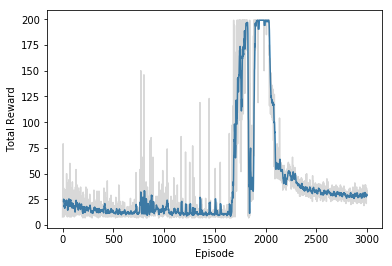

In [22]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Save the trained model 
    saver.restore(sess, 'checkpoints/DQAN-cartpole.ckpt')
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/DQAN-cartpole.ckpt


In [25]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.